<a href="https://colab.research.google.com/github/alivarastepour/Random-Network-Distillation/blob/master/rnd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install stable-baselines3 gymnasium[atari]
!pip install "gymnasium[accept-rom-license, atari]"

In [ ]:
!apt-get install xvfb

In [ ]:
!apt-get install python-opengl ffmpeg
!apt-get update
!apt-get install cmake
!pip install ez_setup
!pip install pyvirtualdisplay

In [38]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import torch.nn as nn
from torch import mean, tensor
import torchvision.transforms.functional as TF
from pyvirtualdisplay import Display
from random import randint
import imageio
from IPython.display import Image

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def start_display():
  display = Display(visible=0, size=(1400, 900))
  display.start()
start_display()

In [16]:
class TargetNetwork(nn.Module):
    def __init__(self, input_channels=3, output_size=18):
        super(TargetNetwork, self).__init__()
        # Simple CNN architecture
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        # Calculate the output size of the conv layers based on input size (210x160)
        # After conv layers: 210x160 -> 51x39 -> 24x18 -> 22x16
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 22 * 16, 512),  # Adjust based on the feature map size
            nn.ReLU(),
            nn.Linear(512, output_size)  # Final output as a feature vector
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

def get_target_nn():
  target_net = TargetNetwork()
  # Freeze the weights of the target network
  for param in target_net.parameters():
      param.requires_grad = False
  return target_net

In [17]:
class PredictionNetwork(nn.Module):
    def __init__(self, input_channels=3, output_size=18):
        super(PredictionNetwork, self).__init__()
        # Same architecture as the target network
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        # Same fully connected layer setup as in the target network
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 22 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

def get_prediction_nn():
  return PredictionNetwork()

In [52]:
class CustomNetwork(nn.Module):
    def __init__(self, input_shape, output_dim):
        super(CustomNetwork, self).__init__()

    def forward(self, x):
        pass

class CustomRewardCallback(BaseCallback):
    def __init__(self, rnd_predictor, rnd_target, verbose=0):
        super(CustomRewardCallback, self).__init__(verbose)
        self.rnd_predictor = rnd_predictor
        self.rnd_target = rnd_target
        self.intrinsic_coeff = 0.09

    def _on_step(self):
        observation = self.locals["obs_tensor"].float()
        target_observation = self.rnd_target(observation)
        prediction_observation = self.rnd_predictor(observation)
        intrinsic_reward = mean((prediction_observation - target_observation) ** 2, dim=1)
        extrinsic_reward = tensor(self.locals["rewards"])
        self.locals["rewards"] = extrinsic_reward + self.intrinsic_coeff * intrinsic_reward.cpu().detach().numpy()
        print("reward ", intrinsic_reward, extrinsic_reward)
        return True

env = gym.make("ALE/FlagCapture-v5", render_mode="rgb_array")
model = PPO("CnnPolicy", env, verbose=1)
callback = CustomRewardCallback(get_prediction_nn(), get_target_nn())

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [53]:
model.learn(total_timesteps=1, callback=callback)
model.save("CnnPolicy")

reward  tensor([21.4296], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.4296], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.4296], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.4296], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.4296], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.4296], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.4296], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.4296], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.3326], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.3326], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.3326], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.3326], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.3326], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.2399], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.2399], grad_fn=<MeanBackward1>) tensor([0.])
reward  tensor([21.3598], grad_fn=<MeanB

In [54]:
model = PPO.load("CnnPolicy",env=env)

vec_env = model.get_env()
obs = vec_env.reset()
frames = []

for i in range(1000):
    action, _states = model.predict(obs)
    print(action)
    _ = vec_env.step(action)
    frame = vec_env.render()
    frames.append(frame)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
[12]
[0]
[8]
[2]
[10]
[9]
[9]
[2]
[16]
[15]
[14]
[10]
[13]
[8]
[3]
[1]
[16]
[1]
[2]
[15]


/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


[1]
[4]
[15]
[9]
[11]
[8]
[13]
[15]
[2]
[0]
[4]
[16]
[3]
[3]
[17]
[10]
[13]
[17]
[6]
[15]
[1]
[17]
[14]
[15]
[8]
[10]
[10]
[11]
[17]
[11]
[10]
[5]
[6]
[9]
[5]
[17]
[6]
[2]
[7]
[7]
[1]
[7]
[9]
[4]
[8]
[11]
[16]
[15]
[17]
[10]
[7]
[3]
[9]
[2]
[0]
[13]
[1]
[10]
[1]
[17]
[3]
[7]
[0]
[10]
[16]
[14]
[3]
[5]
[9]
[11]
[11]
[15]
[13]
[15]
[14]
[6]
[16]
[5]
[16]
[11]
[5]
[0]
[17]
[8]
[16]
[4]
[17]
[15]
[16]
[7]
[16]
[11]
[11]
[12]
[14]
[1]
[2]
[8]
[2]
[9]
[17]
[3]
[12]
[15]
[1]
[5]
[3]
[6]
[12]
[9]
[15]
[11]
[17]
[1]
[7]
[11]
[15]
[5]
[15]
[7]
[13]
[14]
[5]
[1]
[5]
[17]
[2]
[11]
[3]
[3]
[9]
[9]
[4]
[15]
[15]
[7]
[12]
[17]
[17]
[0]
[1]
[1]
[13]
[1]
[8]
[17]
[13]
[17]
[0]
[0]
[9]
[16]
[11]
[1]
[11]
[1]
[10]
[9]
[15]
[0]
[17]
[9]
[0]
[9]
[2]
[9]
[11]
[17]
[4]
[17]
[1]
[15]
[3]
[0]
[0]
[3]
[4]
[13]
[17]
[5]
[0]
[6]
[17]
[0]
[3]
[9]
[10]
[16]
[5]
[0]
[0]
[17]
[1]
[1]
[0]
[10]
[0]
[8]
[12]
[13]
[8]
[12]
[13]
[1]
[13]
[4]
[0]
[16]
[6]
[15]
[0]
[11]
[15]
[10]
[4]
[7]
[7]
[4]
[1]
[2]
[5]
[11]
[17]
[4]
[1

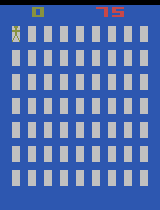

In [56]:
imageio.mimsave('/tmp/cartpole.gif', frames, fps=1)
Image(filename='/tmp/cartpole.gif')

In [ ]:
env.close()